In [1]:
import glob
from TSP_Formulation_Methods import *
import matplotlib.pyplot as plt
import numpy as np

N = 5
p = 2
num_reads_solver = 4000

concrete_simulations = "lambdas"
mean_lambdas = load_lambda_means(concrete_simulations)

print("Mean lambdas: ", mean_lambdas)
distances_original_matrix = np.loadtxt("./data/matriz-rutas-granada")
all_start_end_combinations = generate_all_start_end_combinations(N, L=1)
distances_N_stops_normalized = distances_original_matrix[:N,:N]/np.max(distances_original_matrix[:N,:N])

Mean lambdas:  [1.9738499612356164, 2.613243900629556, 1.1344560218416773, 2.4768802642659193, 3.740516627902282]


Weight λ1: Mean = 1.9738, Variance = 0.0536
Weight λ2: Mean = 2.6132, Variance = 0.3889
Weight λ3: Mean = 1.1345, Variance = 0.1804
Weight λ4: Mean = 2.4769, Variance = 0.1865
Weight λ5: Mean = 3.7405, Variance = 0.3115


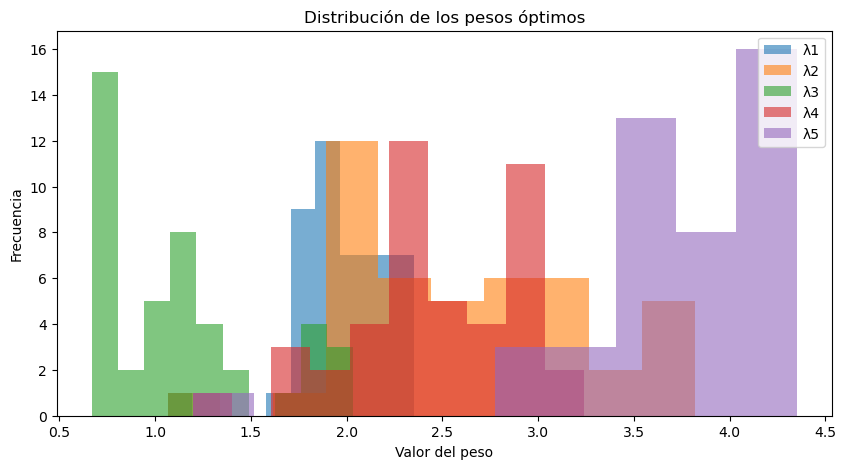

In [2]:
files_to_find = "./data/lamdasOptimized/"+concrete_simulations+"*"
files = glob.glob(files_to_find)

all_weights = []

for file in files:
    weights = np.loadtxt(file)
    all_weights.append(weights)

all_weights = np.array(all_weights)  # Shape: (num_files, 5)

means = np.mean(all_weights, axis=0)
variances = np.var(all_weights, axis=0)

for i in range(5):
    print(f"Weight λ{i+1}: Mean = {means[i]:.4f}, Variance = {variances[i]:.4f}")

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.hist(all_weights[:, i], bins=10, alpha=0.6, label=f"λ{i+1}")
plt.xlabel("Valor del peso")
plt.ylabel("Frecuencia")
plt.title("Distribución de los pesos óptimos")
plt.legend()
plt.show()

/tmp/ipykernel_23925/3380596703.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_weights, labels=[f"λ{i+1}" for i in range(5)])


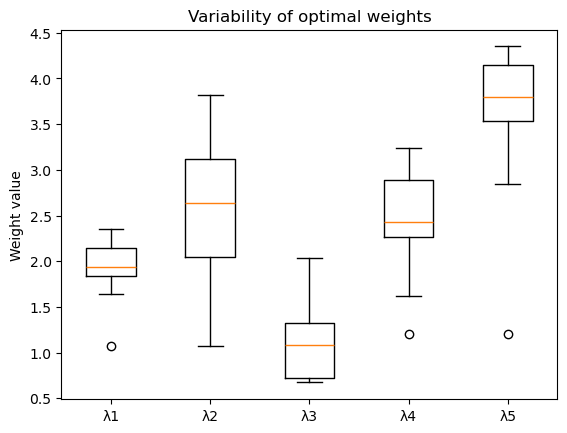

In [3]:
plt.boxplot(all_weights, labels=[f"λ{i+1}" for i in range(5)])
plt.ylabel("Weight value")
plt.title("Variability of optimal weights")
plt.show()

In [4]:
# Check on how accurate are the mean weights for each combination of start and end stops

solutions_analysis = np.zeros((len(all_start_end_combinations), 3))

for index, (startNodes, endNodes) in enumerate(all_start_end_combinations):
    startNode = startNodes[0]
    endNode = endNodes[0]
    solutions_analysis[index][0] = startNode
    solutions_analysis[index][1] = endNode
    Q_matrix,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, mean_lambdas)
    solution_array, _ = solve_qubo_with_Dwave(Q_matrix, num_reads_solver)
    solutions_analysis[index][2] = int(check_solution_return(solution_array, N, p, startNode, endNode))

show_statistics_lambdas(solutions_analysis)


Percentage of correct solutions: 1.00

Percentage of correct solutions starting at node 0: 1.00
Percentage of correct solutions ending at node 0: nan

Percentage of correct solutions starting at node 1: 1.00
Percentage of correct solutions ending at node 1: 1.00

Percentage of correct solutions starting at node 2: 1.00
Percentage of correct solutions ending at node 2: 1.00

Percentage of correct solutions starting at node 3: 1.00
Percentage of correct solutions ending at node 3: 1.00

Percentage of correct solutions starting at node 4: nan
Percentage of correct solutions ending at node 4: 1.00



/home/josema/Documentos/universidad/uimp/pasqal/pasqal_challenge/TSP_Formulation_Methods.py:650: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_end_i = correct_solutions_end_i/total_solutions_end_i
/home/josema/Documentos/universidad/uimp/pasqal/pasqal_challenge/TSP_Formulation_Methods.py:644: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_start_i = correct_solutions_start_i/total_solutions_start_i


In [36]:
# Modified version of mean lambdas


concrete_simulations = "lambdas_N_{}_p_{}".format(N, p)
mean_lambdas = load_lambda_means(concrete_simulations)
modified_mean_lambdas = [np.abs(5-i)*mean_lambdas[i] for i in range(5)]
num_reads_solver = 1000

solutions_analysis = np.zeros((len(all_start_end_combinations), 3))

for index, (startNodes, endNodes) in enumerate(all_start_end_combinations):
    startNode = startNodes[0]
    endNode = endNodes[0]
    solutions_analysis[index][0] = startNode
    solutions_analysis[index][1] = endNode
    Q_matrix,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, modified_mean_lambdas)
    solution_array, _ = solve_qubo_with_Dwave(Q_matrix, num_reads_solver)
    solutions_analysis[index][2] = int(check_solution_return(solution_array, N, p, startNode, endNode))

# Sum over all the solutions that are correct
correct_solutions = np.sum(solutions_analysis[:,2])

# Relative percentage of correct solutions
percentage_correct_solutions = correct_solutions/len(all_start_end_combinations)

print(f"Percentage of correct solutions: {percentage_correct_solutions:.2f}\n")

for i in range(5):
    correct_solutions_start_i = np.sum(solutions_analysis[np.where(solutions_analysis[:,0] == i)][:,2])
    total_solutions_start_i = len(solutions_analysis[np.where(solutions_analysis[:,0] == i)])
    percentage_correct_solutions_start_i = correct_solutions_start_i/total_solutions_start_i

    print(f"Percentage of correct solutions starting at node {i}: {percentage_correct_solutions_start_i:.2f}")

    correct_solutions_end_i = np.sum(solutions_analysis[np.where(solutions_analysis[:,1] == i)][:,2])
    total_solutions_end_i = len(solutions_analysis[np.where(solutions_analysis[:,1] == i)])
    percentage_correct_solutions_end_i = correct_solutions_end_i/total_solutions_end_i

    print(f"Percentage of correct solutions ending at node {i}: {percentage_correct_solutions_end_i:.2f}\n")

Percentage of correct solutions: 1.00

Percentage of correct solutions starting at node 0: 1.00
Percentage of correct solutions ending at node 0: 1.00

Percentage of correct solutions starting at node 1: 1.00
Percentage of correct solutions ending at node 1: 1.00

Percentage of correct solutions starting at node 2: 1.00
Percentage of correct solutions ending at node 2: 1.00

Percentage of correct solutions starting at node 3: 1.00
Percentage of correct solutions ending at node 3: 1.00

Percentage of correct solutions starting at node 4: nan
Percentage of correct solutions ending at node 4: nan



/tmp/ipykernel_33475/1261336979.py:31: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_start_i = correct_solutions_start_i/total_solutions_start_i
/tmp/ipykernel_33475/1261336979.py:37: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_end_i = correct_solutions_end_i/total_solutions_end_i


Weight λ1: Mean = 4.6557, Variance = 0.2084
Weight λ2: Mean = 2.5605, Variance = 0.1179
Weight λ3: Mean = 1.4957, Variance = 0.2145
Weight λ4: Mean = 2.6033, Variance = 0.0155
Weight λ5: Mean = 4.0243, Variance = 0.0628


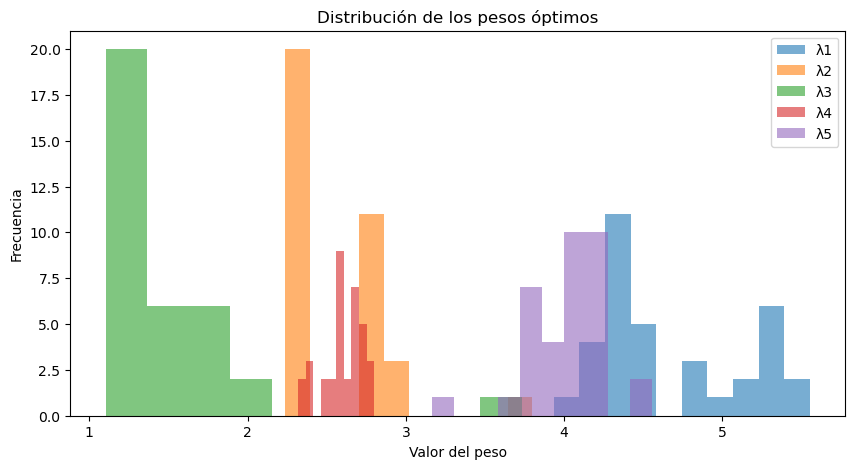

In [37]:
# Analysis of the mean lambdas without specifyng the number of stops or travels

import glob
import matplotlib.pyplot as plt
import numpy as np

concrete_simulations = "lambdas"
files_to_find = "./data/lamdasOptimized/"+concrete_simulations+"*"
files = glob.glob(files_to_find)

all_weights = []

for file in files:
    weights = np.loadtxt(file)
    all_weights.append(weights)

all_weights = np.array(all_weights)  # Shape: (num_files, 5)

means = np.mean(all_weights, axis=0)
variances = np.var(all_weights, axis=0)

for i in range(5):
    print(f"Weight λ{i+1}: Mean = {means[i]:.4f}, Variance = {variances[i]:.4f}")

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.hist(all_weights[:, i], bins=10, alpha=0.6, label=f"λ{i+1}")
plt.xlabel("Valor del peso")
plt.ylabel("Frecuencia")
plt.title("Distribución de los pesos óptimos")
plt.legend()
plt.show()

/tmp/ipykernel_33475/1209483300.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_weights, labels=[f"λ{i+1}" for i in range(5)])


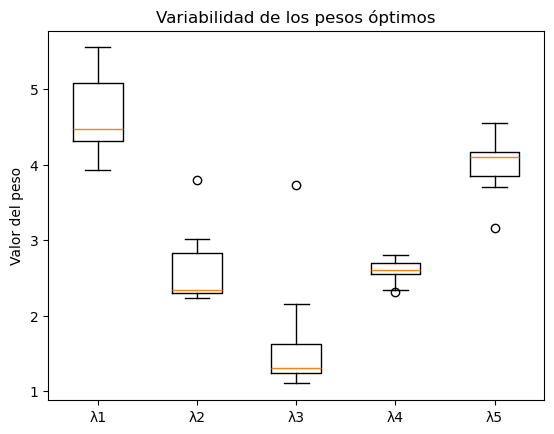

In [38]:
plt.boxplot(all_weights, labels=[f"λ{i+1}" for i in range(5)])
plt.ylabel("Valor del peso")
plt.title("Variabilidad de los pesos óptimos")
plt.show()

In [42]:
# Check on how accurate are the mean weights for each combination of start and end stops

from TSP_Formulation_Methods import *
import numpy as np

distances_original_matrix = np.loadtxt("./data/matriz-rutas-granada")

N = 4# Number of stops
p = 2 # Number of travels, aka number of edges. The number of involucred stops is then p+1
L = 1

concrete_simulations = "lambdas"
mean_lambdas = load_lambda_means(concrete_simulations)
all_start_end_combinations = generate_all_start_end_combinations(N, L)
distances_N_stops_normalized = distances_original_matrix[:N,:N]/np.max(distances_original_matrix[:N,:N])
num_reads_solver = 1000

solutions_analysis = np.zeros((len(all_start_end_combinations), 3))

for index, (startNodes, endNodes) in enumerate(all_start_end_combinations):
    startNode = startNodes[0]
    endNode = endNodes[0]
    solutions_analysis[index][0] = startNode
    solutions_analysis[index][1] = endNode
    Q_matrix,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, mean_lambdas)
    solution_array, _ = solve_qubo_with_Dwave(Q_matrix, num_reads_solver)
    solutions_analysis[index][2] = int(check_solution_return(solution_array, N, p, startNode, endNode))

# Sum over all the solutions that are correct
correct_solutions = np.sum(solutions_analysis[:,2])

# Relative percentage of correct solutions
percentage_correct_solutions = correct_solutions/len(all_start_end_combinations)

print(f"Percentage of correct solutions: {percentage_correct_solutions:.2f}\n")

for i in range(5):
    correct_solutions_start_i = np.sum(solutions_analysis[np.where(solutions_analysis[:,0] == i)][:,2])
    total_solutions_start_i = len(solutions_analysis[np.where(solutions_analysis[:,0] == i)])
    percentage_correct_solutions_start_i = correct_solutions_start_i/total_solutions_start_i

    print(f"Percentage of correct solutions starting at node {i}: {percentage_correct_solutions_start_i:.2f}")

    correct_solutions_end_i = np.sum(solutions_analysis[np.where(solutions_analysis[:,1] == i)][:,2])
    total_solutions_end_i = len(solutions_analysis[np.where(solutions_analysis[:,1] == i)])
    percentage_correct_solutions_end_i = correct_solutions_end_i/total_solutions_end_i

    print(f"Percentage of correct solutions ending at node {i}: {percentage_correct_solutions_end_i:.2f}\n")

Percentage of correct solutions: 0.50

Percentage of correct solutions starting at node 0: 0.67
Percentage of correct solutions ending at node 0: 0.67

Percentage of correct solutions starting at node 1: 0.33
Percentage of correct solutions ending at node 1: 0.33

Percentage of correct solutions starting at node 2: 0.33
Percentage of correct solutions ending at node 2: 0.33

Percentage of correct solutions starting at node 3: 0.67
Percentage of correct solutions ending at node 3: 0.67

Percentage of correct solutions starting at node 4: nan
Percentage of correct solutions ending at node 4: nan



/tmp/ipykernel_33475/1800842676.py:40: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_start_i = correct_solutions_start_i/total_solutions_start_i
/tmp/ipykernel_33475/1800842676.py:46: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_end_i = correct_solutions_end_i/total_solutions_end_i


In [43]:
# Modified version of mean lambdas


concrete_simulations = "lambdas"
mean_lambdas = load_lambda_means(concrete_simulations)
modified_mean_lambdas = [np.abs(5-i)*mean_lambdas[i] for i in range(5)]
num_reads_solver = 1000

solutions_analysis = np.zeros((len(all_start_end_combinations), 3))

for index, (startNodes, endNodes) in enumerate(all_start_end_combinations):
    startNode = startNodes[0]
    endNode = endNodes[0]
    solutions_analysis[index][0] = startNode
    solutions_analysis[index][1] = endNode
    Q_matrix,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, modified_mean_lambdas)
    solution_array, _ = solve_qubo_with_Dwave(Q_matrix, num_reads_solver)
    solutions_analysis[index][2] = int(check_solution_return(solution_array, N, p, startNode, endNode))

# Sum over all the solutions that are correct
correct_solutions = np.sum(solutions_analysis[:,2])

# Relative percentage of correct solutions
percentage_correct_solutions = correct_solutions/len(all_start_end_combinations)

print(f"Percentage of correct solutions: {percentage_correct_solutions:.2f}\n")

for i in range(5):
    correct_solutions_start_i = np.sum(solutions_analysis[np.where(solutions_analysis[:,0] == i)][:,2])
    total_solutions_start_i = len(solutions_analysis[np.where(solutions_analysis[:,0] == i)])
    percentage_correct_solutions_start_i = correct_solutions_start_i/total_solutions_start_i

    print(f"Percentage of correct solutions starting at node {i}: {percentage_correct_solutions_start_i:.2f}")

    correct_solutions_end_i = np.sum(solutions_analysis[np.where(solutions_analysis[:,1] == i)][:,2])
    total_solutions_end_i = len(solutions_analysis[np.where(solutions_analysis[:,1] == i)])
    percentage_correct_solutions_end_i = correct_solutions_end_i/total_solutions_end_i

    print(f"Percentage of correct solutions ending at node {i}: {percentage_correct_solutions_end_i:.2f}\n")

Percentage of correct solutions: 1.00

Percentage of correct solutions starting at node 0: 1.00
Percentage of correct solutions ending at node 0: 1.00

Percentage of correct solutions starting at node 1: 1.00
Percentage of correct solutions ending at node 1: 1.00

Percentage of correct solutions starting at node 2: 1.00
Percentage of correct solutions ending at node 2: 1.00

Percentage of correct solutions starting at node 3: 1.00
Percentage of correct solutions ending at node 3: 1.00

Percentage of correct solutions starting at node 4: nan
Percentage of correct solutions ending at node 4: nan



/tmp/ipykernel_33475/1932705625.py:31: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_start_i = correct_solutions_start_i/total_solutions_start_i
/tmp/ipykernel_33475/1932705625.py:37: RuntimeWarning: invalid value encountered in scalar divide
  percentage_correct_solutions_end_i = correct_solutions_end_i/total_solutions_end_i
